# Performance evaluation of different pyroaring versions

We measured the performance of many bitmap operations with different pyroaring functions. The experiment was carried on one node from the [dahu](https://www.grid5000.fr/w/Grenoble:Hardware#dahu) cluster of Grid'5000, (Intel Xeon Gold 6130, Skylake, 2.10GHz, 2 CPUs/node, 16 cores/CPU), running on the default Grid'5000 image (Debian 10.10 with kernel 4.19.0, GCC 8.3.0 and Python 3.7.3).

The experiment was carried by running the `version_benchmark.sh` script, which uses the `benchmark.py` program. It tested ten times all the pyroaring versions from `0.2.0` to `0.3.3` in a random order. For each run, we tested three different bitmap densities (0.01, 0.2, 0.99) and all the bitmap operations in a random order. The measure for a given density and operation is repeated 100 times, the average duration is then reported.

Each time, `pyroaring` is installed from the `*.tar.gz` file from [Github releases](https://github.com/Ezibenroc/PyRoaringBitMap/releases). This means that the Cython code has already been compiled to C++, but the C/C++ code has not yet been compiled to machine instructions. Note that different Cython versions have very likely been used throughout the years, this could be an important experimental bias.

Note: the bitmaps have $S=1000000$ elements and are randomly and uniformly generated. The density refers to the probability that a given element is chosen. More precisely, with a density $d$, we sampled randomly $S$ elements from the interval $[0,S/d]$. This will affect the kind of container that we are more likely to have. With $d=0.01$, we mostly have array containers, with $d=0.2$ we mostly have bitset containers and with $d=0.99$ we mostly have run containers.

## Loading the data

In [1]:
library(dplyr)
library(ggplot2)
library(repr)
library(readr)

options(repr.plot.width=12, repr.plot.height=8)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
df = read.csv('data/version_evaluation_2021-09-13.csv') %>%
    mutate(density = factor(density)) %>%
    mutate(timestamp = parse_datetime(as.character(timestamp))) %>%
    mutate(pyroaring_version = factor(pyroaring_version, levels=c("0.2.0","0.2.1","0.2.2","0.2.3","0.2.4","0.2.5","0.2.6","0.2.7","0.2.8","0.2.9","0.2.10","0.2.11","0.3.0","0.3.1","0.3.2","0.3.3")))
df %>% head()

operation,density,size,time,timestamp,nb_calls,pyroaring_version,pyroaring_git_version,croaring_version,croaring_git_version
<fct>,<fct>,<int>,<dbl>,<dttm>,<int>,<fct>,<fct>,<fct>,<fct>
conversion to list,0.2,1000000,4.295427e-02,2021-09-13 18:21:43,100,0.2.0,f23883bf21a9d5ae55178fc0aa126f19c23ad945,v0.2.42,9fb22ceb7273b4eca92c1eb114910c3dab312460
equality test,0.2,1000000,4.797251e-05,2021-09-13 18:21:49,100,0.2.0,f23883bf21a9d5ae55178fc0aa126f19c23ad945,v0.2.42,9fb22ceb7273b4eca92c1eb114910c3dab312460
intersection,0.99,1000000,1.177736e-04,2021-09-13 18:21:49,100,0.2.0,f23883bf21a9d5ae55178fc0aa126f19c23ad945,v0.2.42,9fb22ceb7273b4eca92c1eb114910c3dab312460
selection,0.2,1000000,5.590000e-07,2021-09-13 18:21:51,100,0.2.0,f23883bf21a9d5ae55178fc0aa126f19c23ad945,v0.2.42,9fb22ceb7273b4eca92c1eb114910c3dab312460
element removal,0.01,1000000,1.382400e-07,2021-09-13 18:21:52,100,0.2.0,f23883bf21a9d5ae55178fc0aa126f19c23ad945,v0.2.42,9fb22ceb7273b4eca92c1eb114910c3dab312460
small slice,0.99,1000000,3.925521e-05,2021-09-13 18:21:52,100,0.2.0,f23883bf21a9d5ae55178fc0aa126f19c23ad945,v0.2.42,9fb22ceb7273b4eca92c1eb114910c3dab312460


## CRoaring version used by each pyroaring version

In [3]:
df %>%
    select(pyroaring_version, croaring_version) %>%
    unique() %>%
    arrange(pyroaring_version)

pyroaring_version,croaring_version
<fct>,<fct>
0.2.0,v0.2.42
0.2.1,v0.2.42
0.2.2,v0.2.43
0.2.3,v0.2.51
0.2.4,v0.2.55
0.2.5,v0.2.55
0.2.6,v0.2.57
0.2.7,v0.2.62
0.2.8,v0.2.63


## Visualization of the performance

In the next cell, we plot the durations of each operation for all the versions and densities. Each point is the average of 100 measures. The boxes represent a 99% confidence interval for the estimation of the mean, assuming a normal distribution of the points.

Warning: the Y axis always starts at 0, but different scales are used for the different densities and operations.

`summarise()` ungrouping output (override with `.groups` argument)


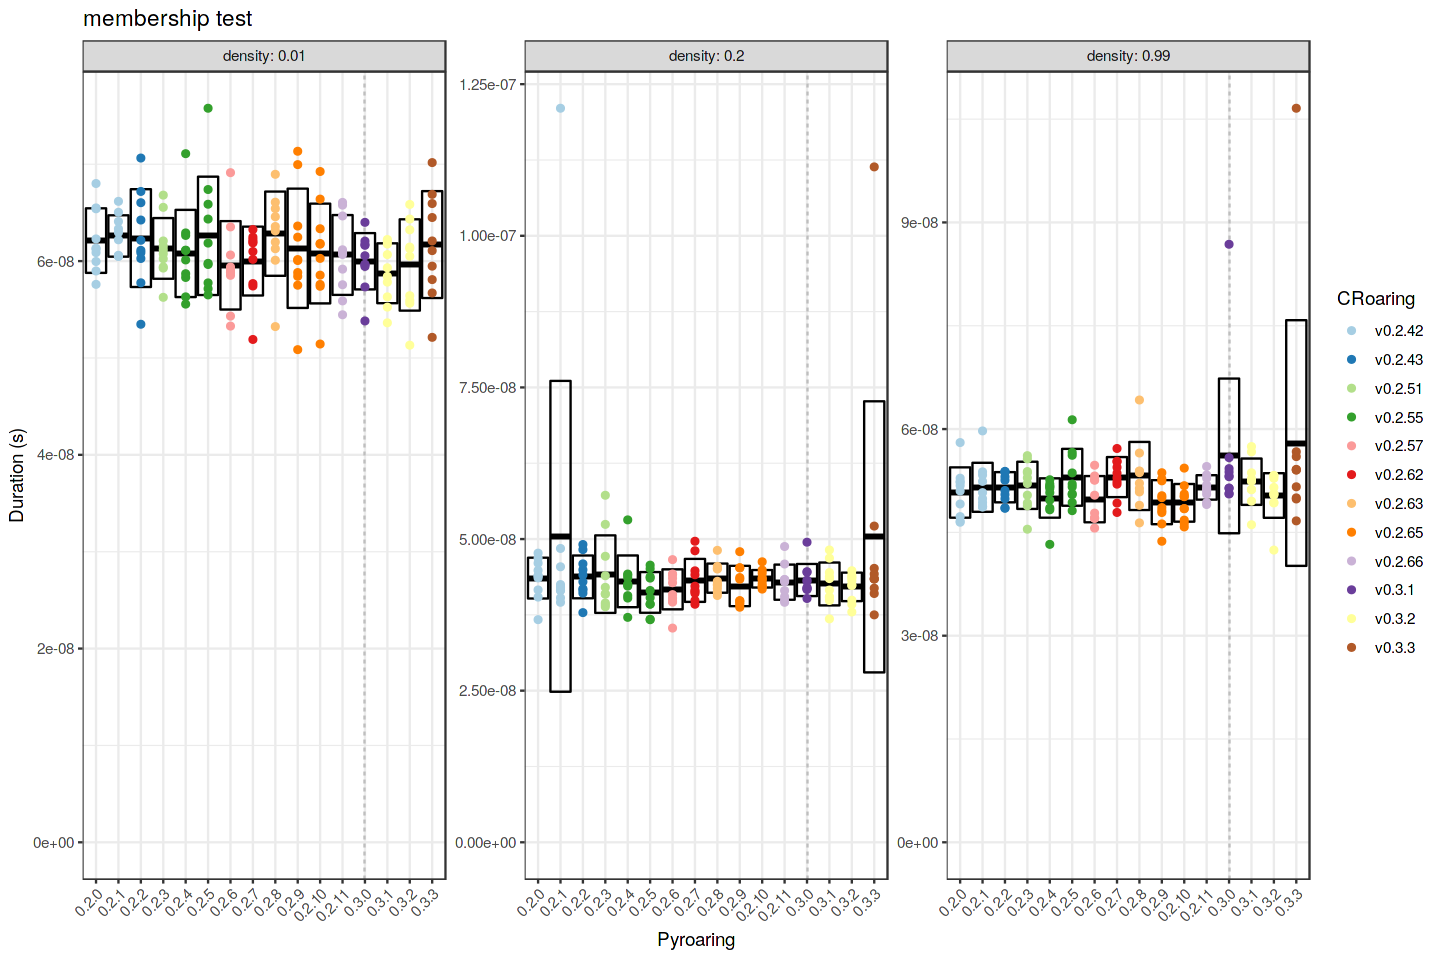

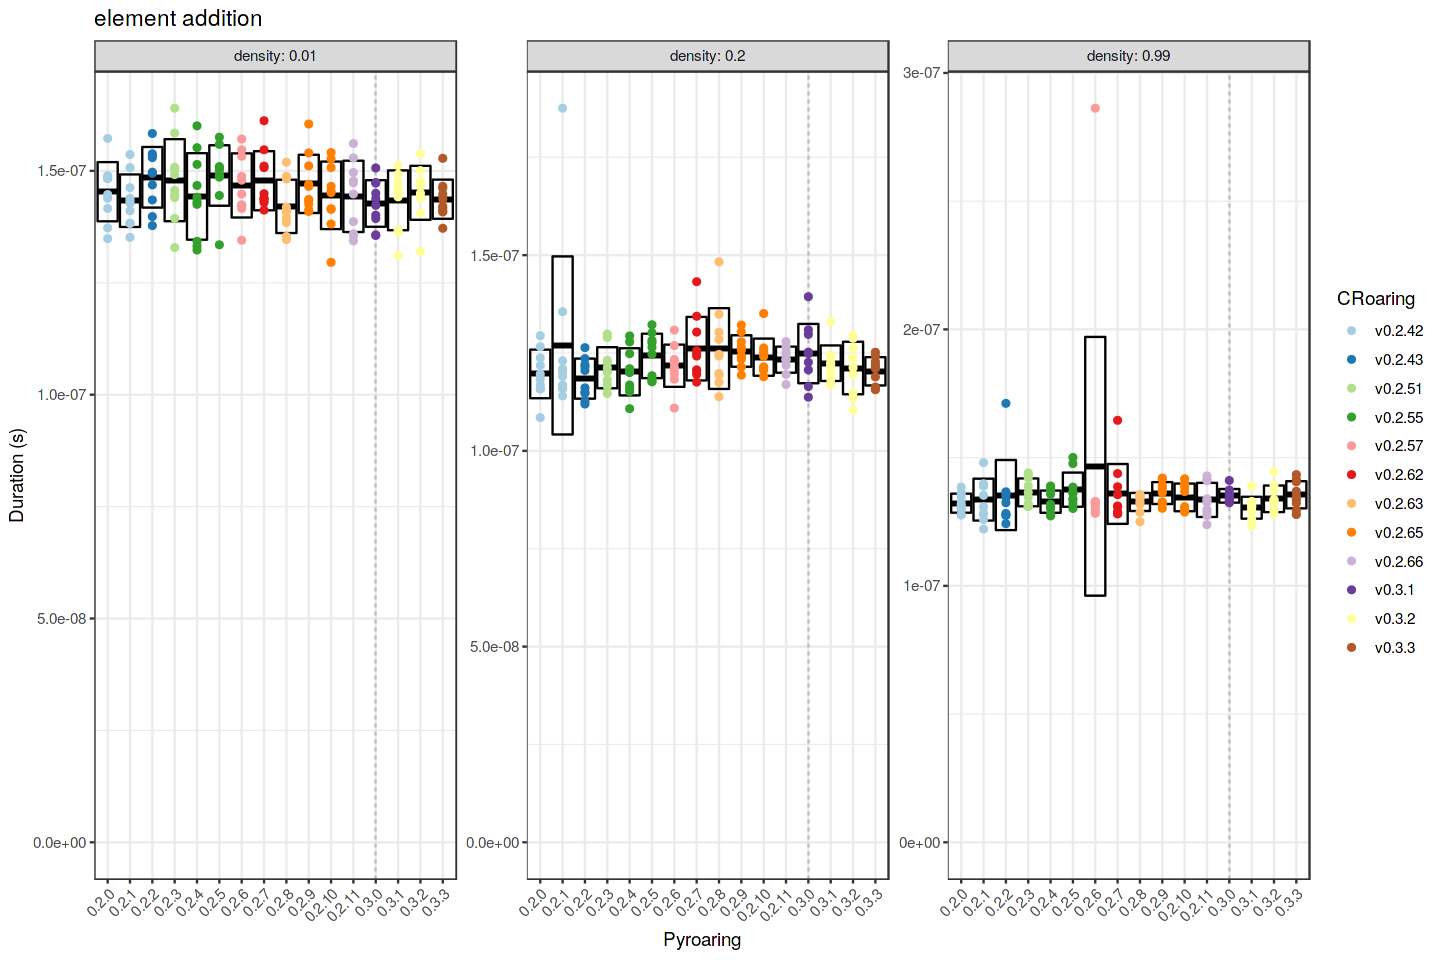

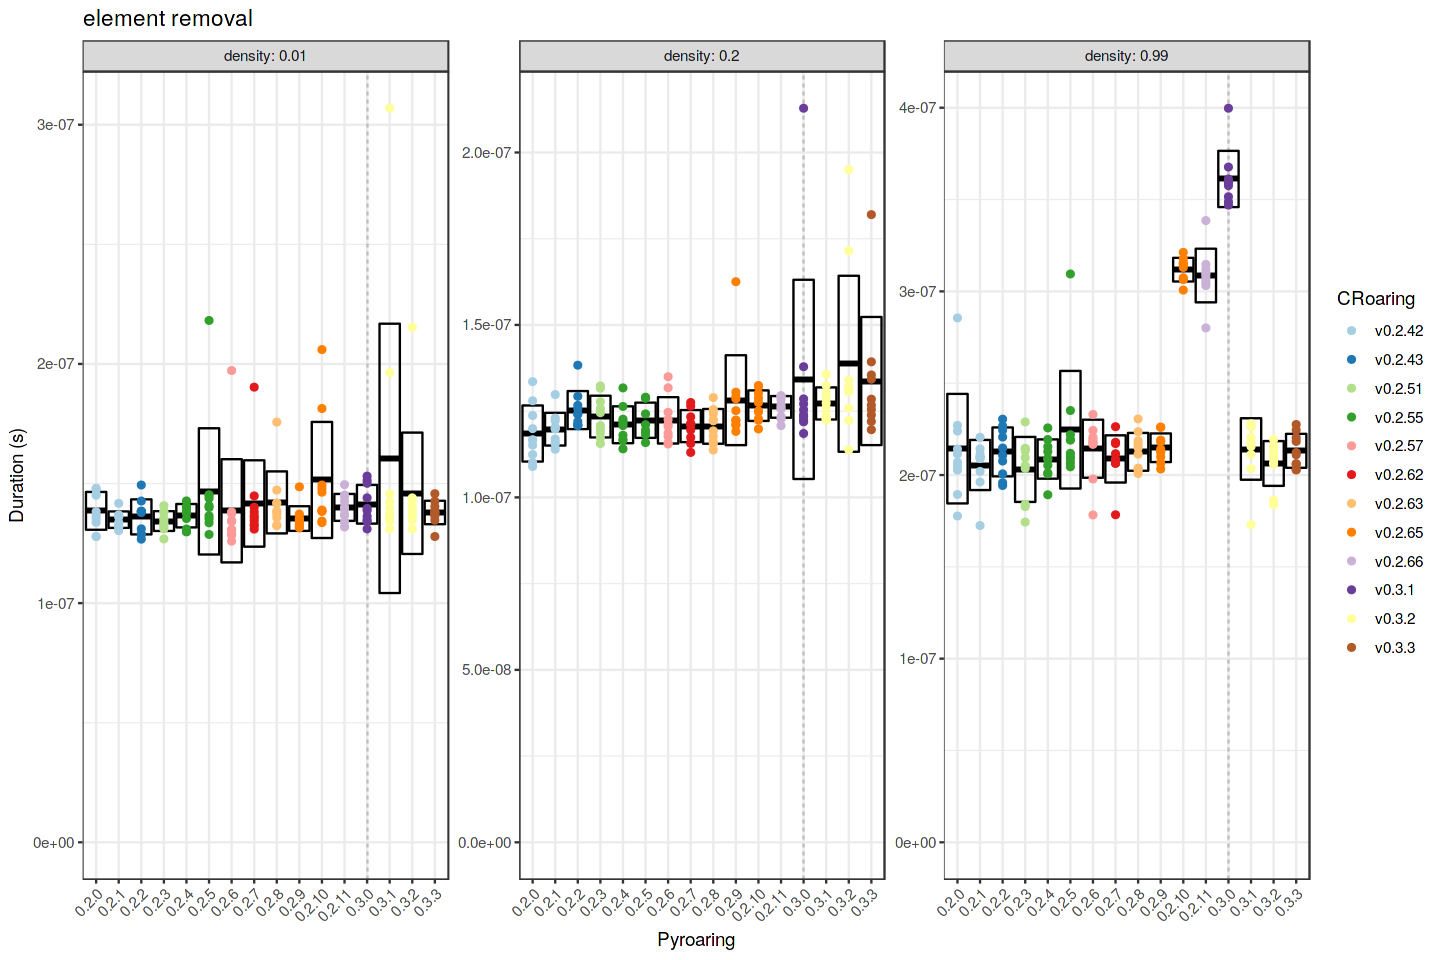

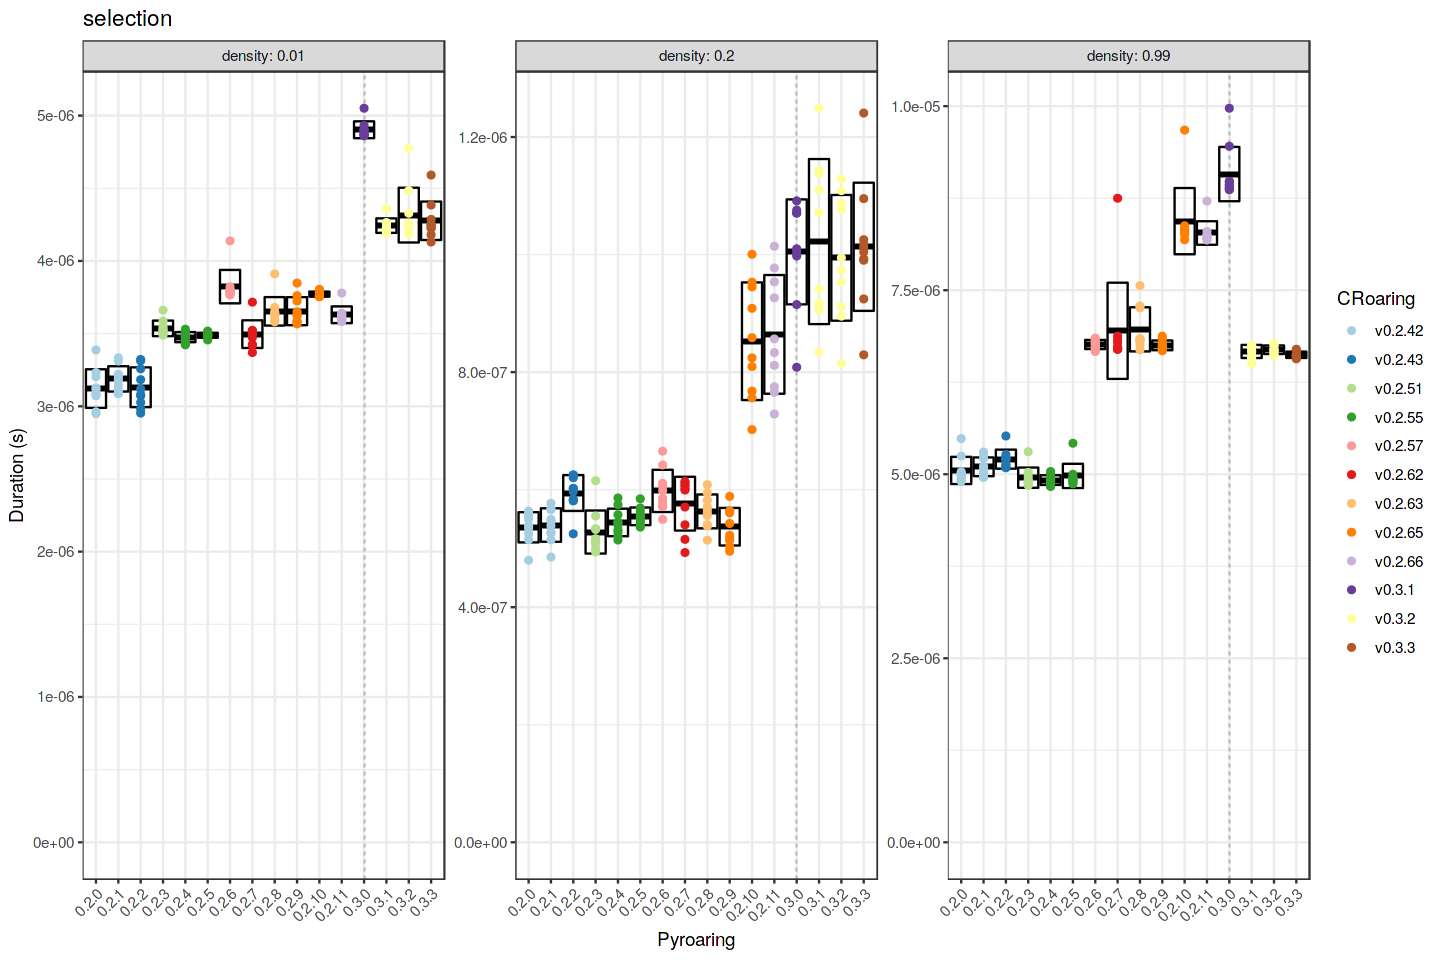

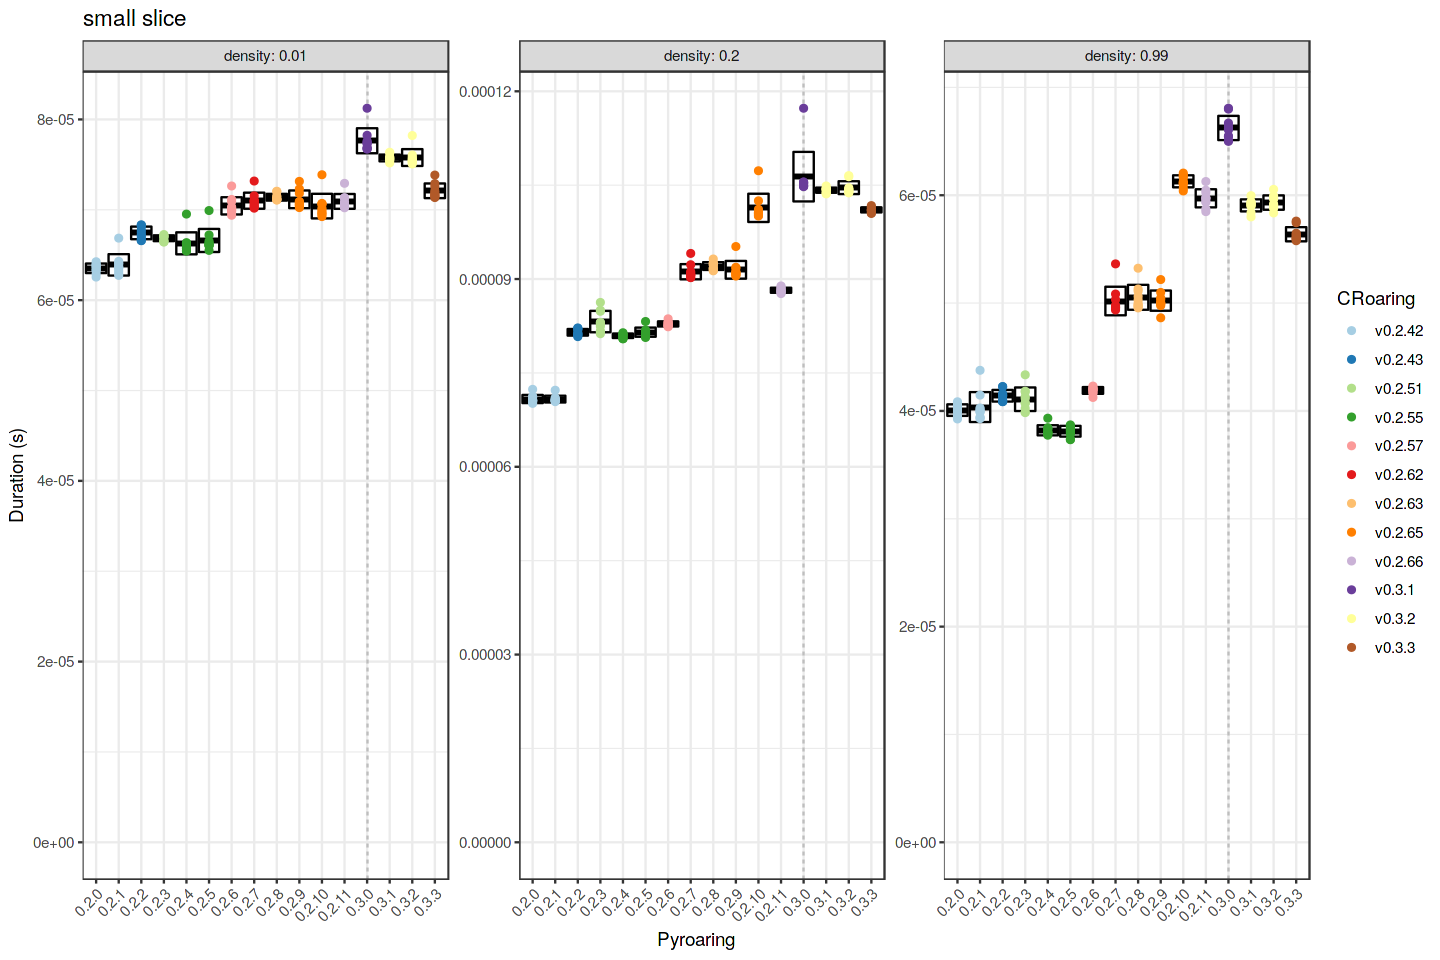

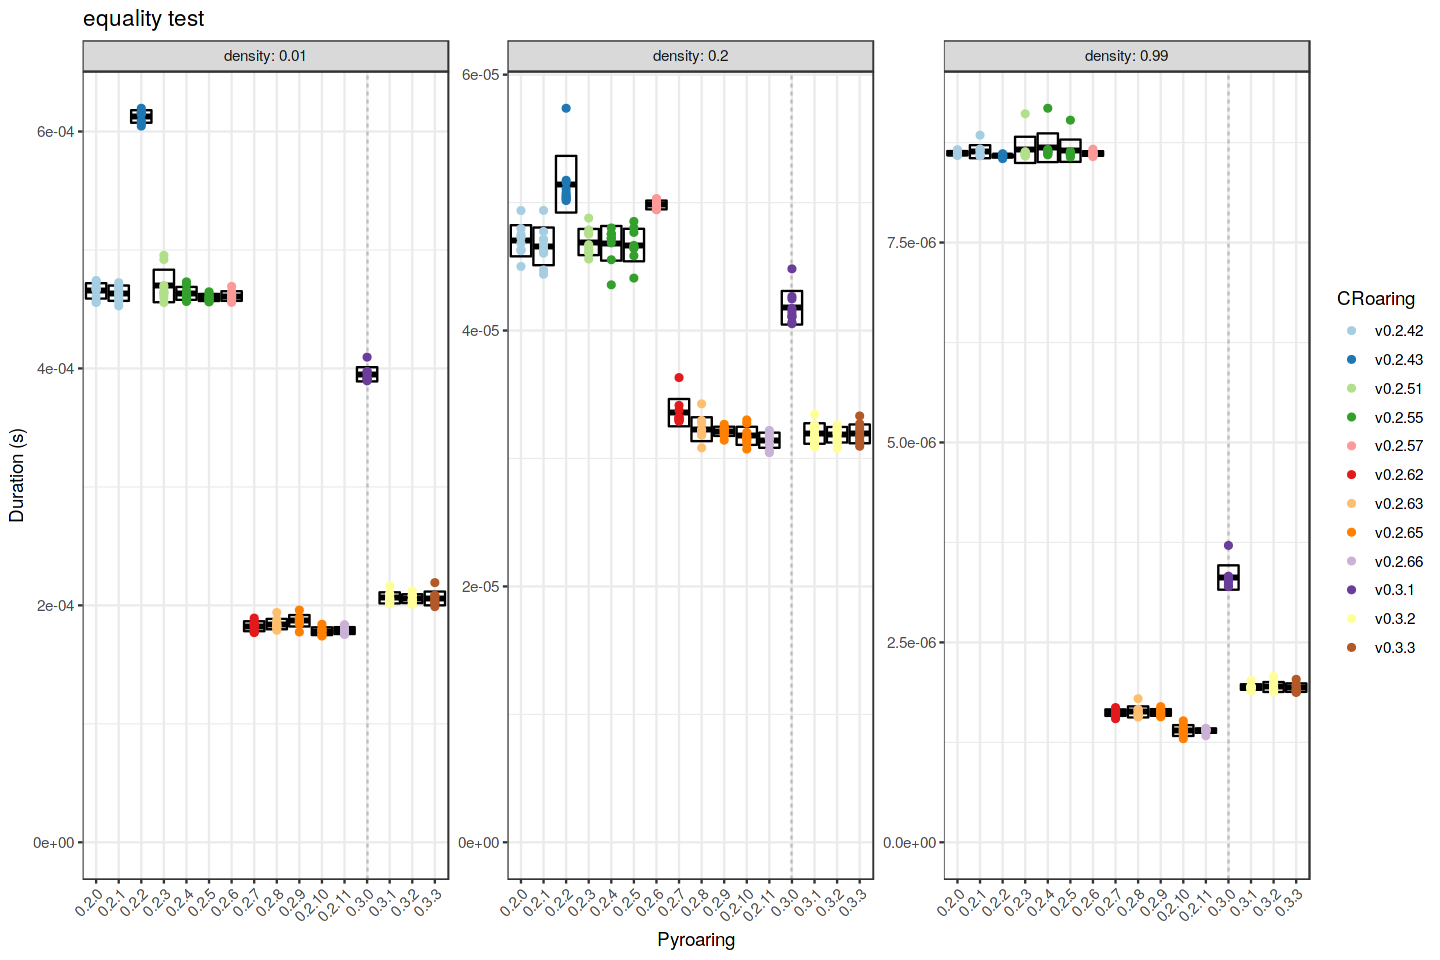

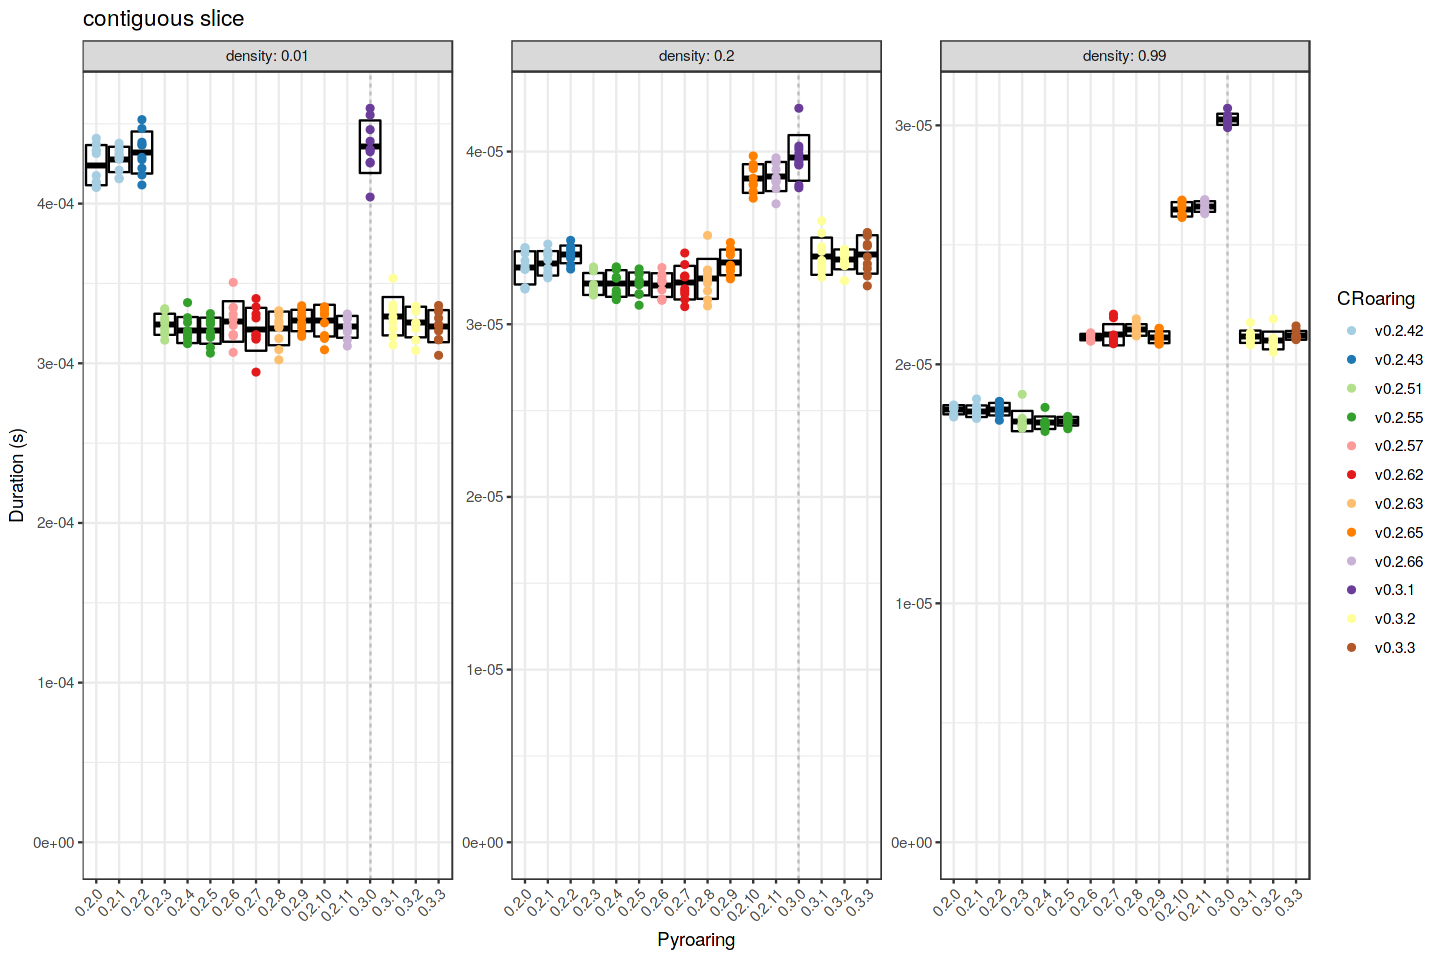

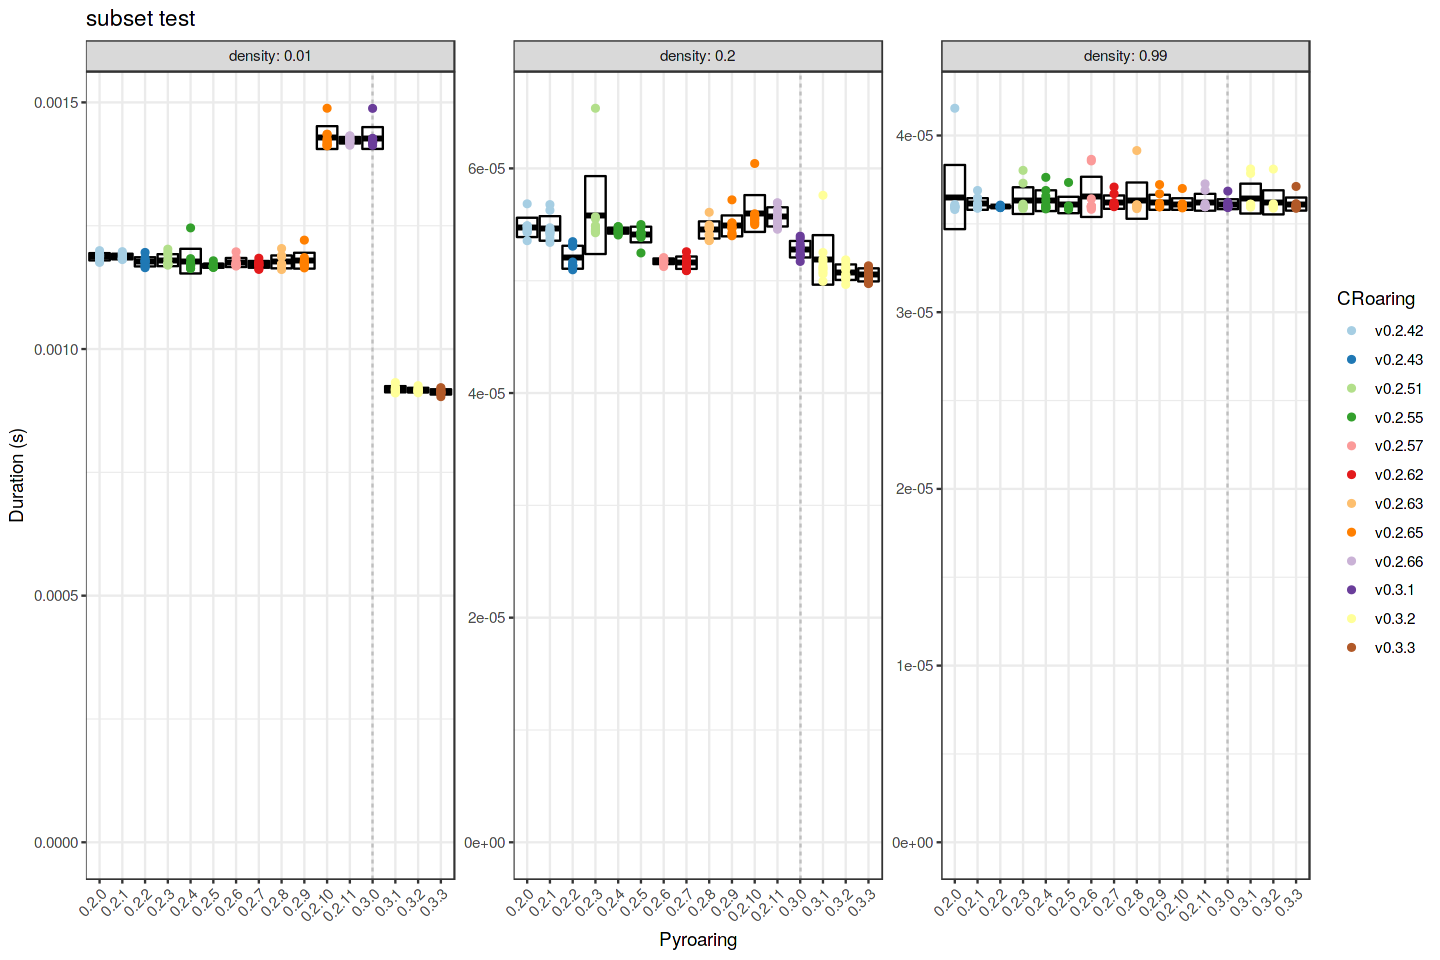

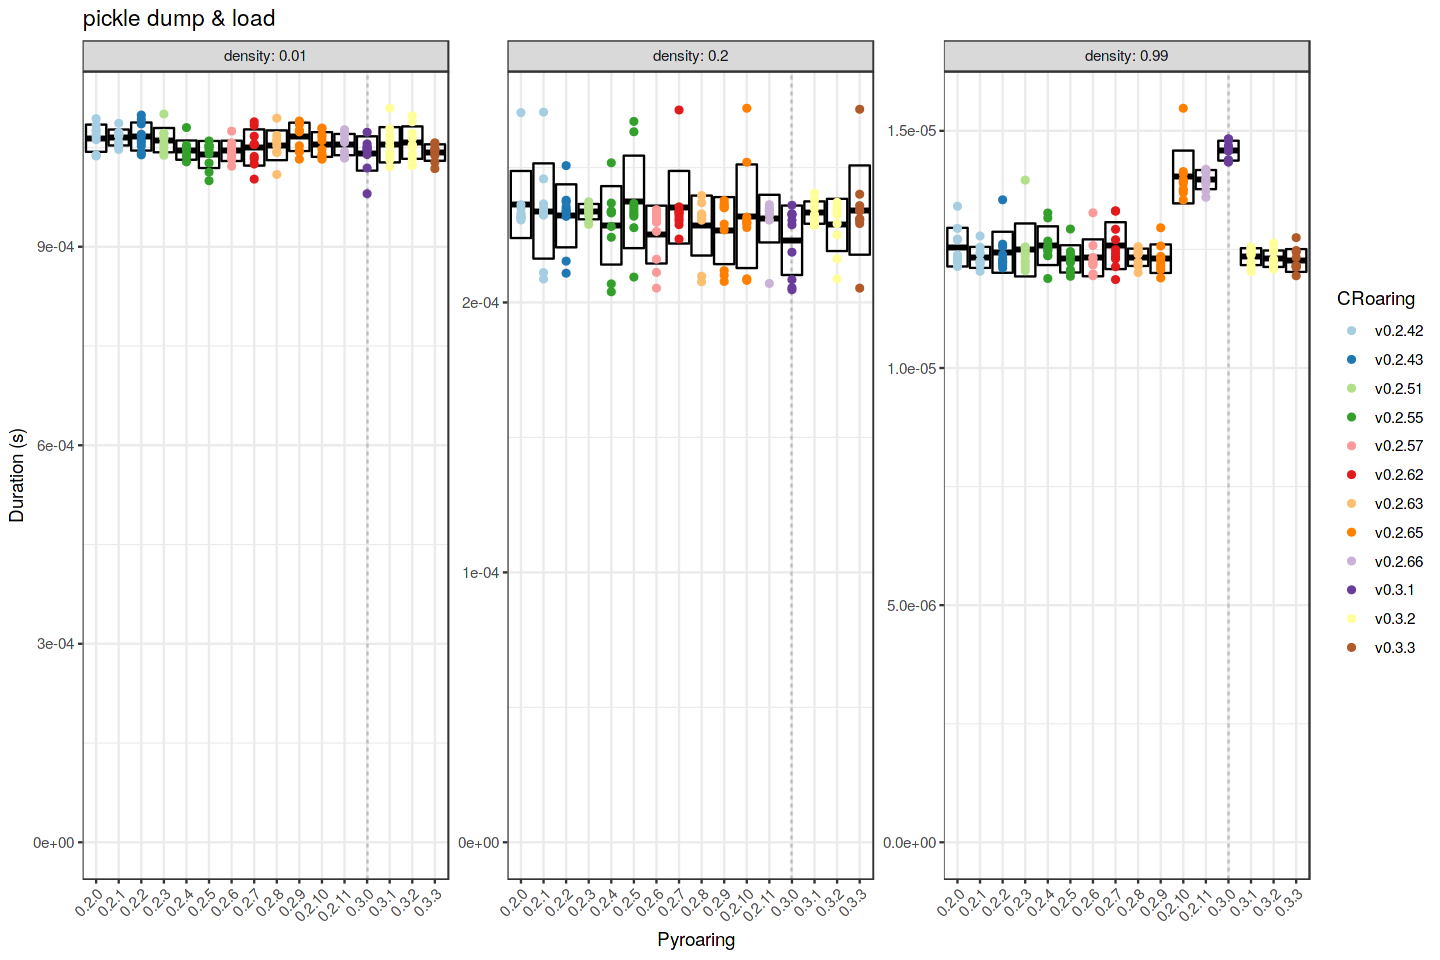

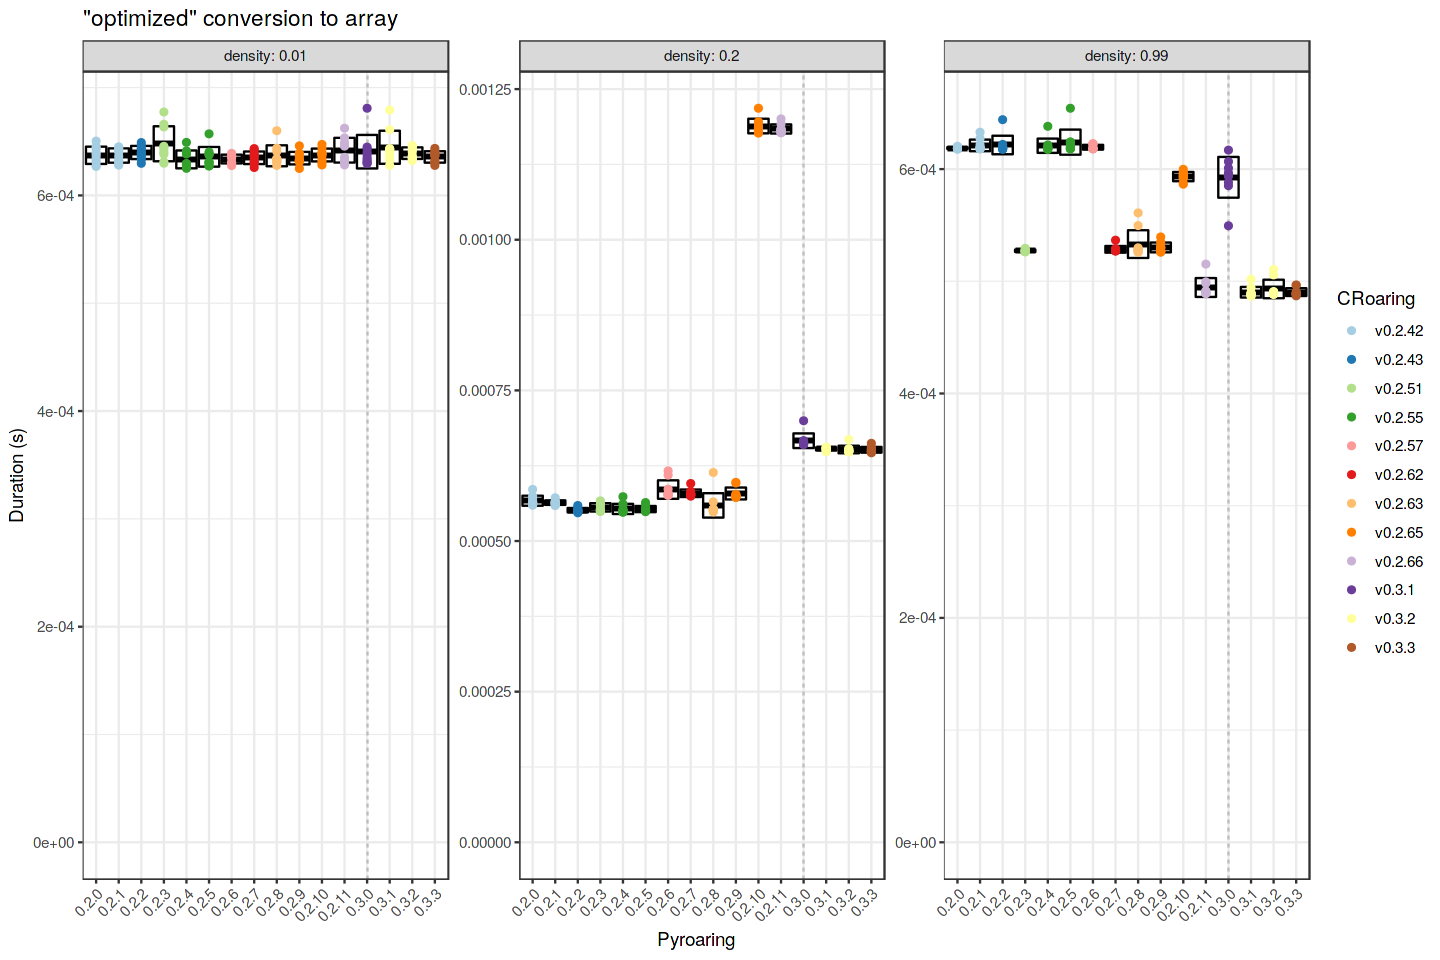

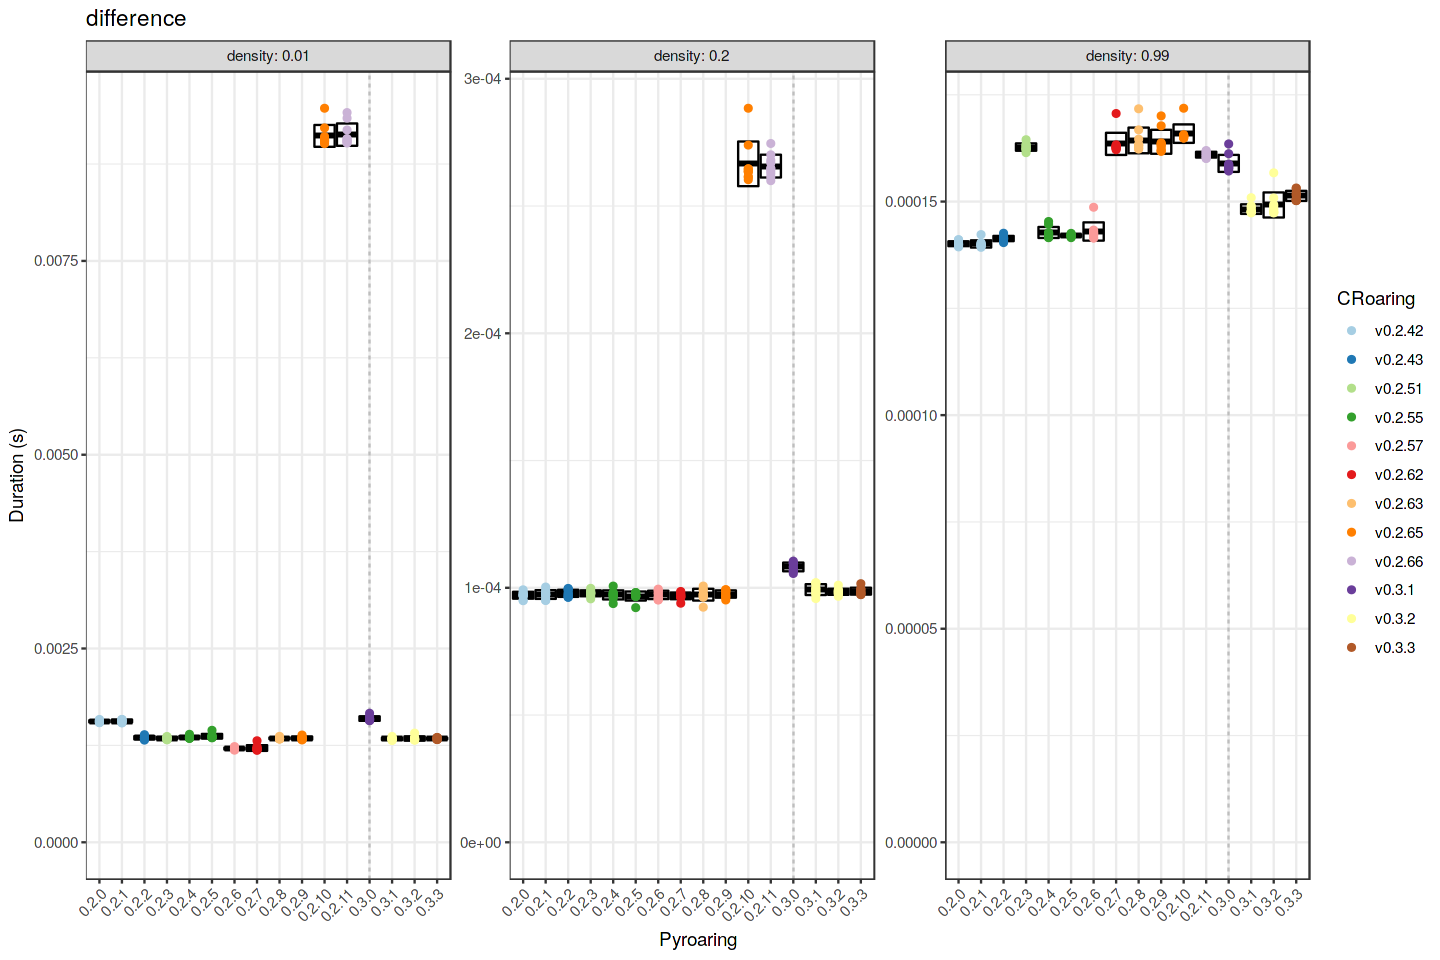

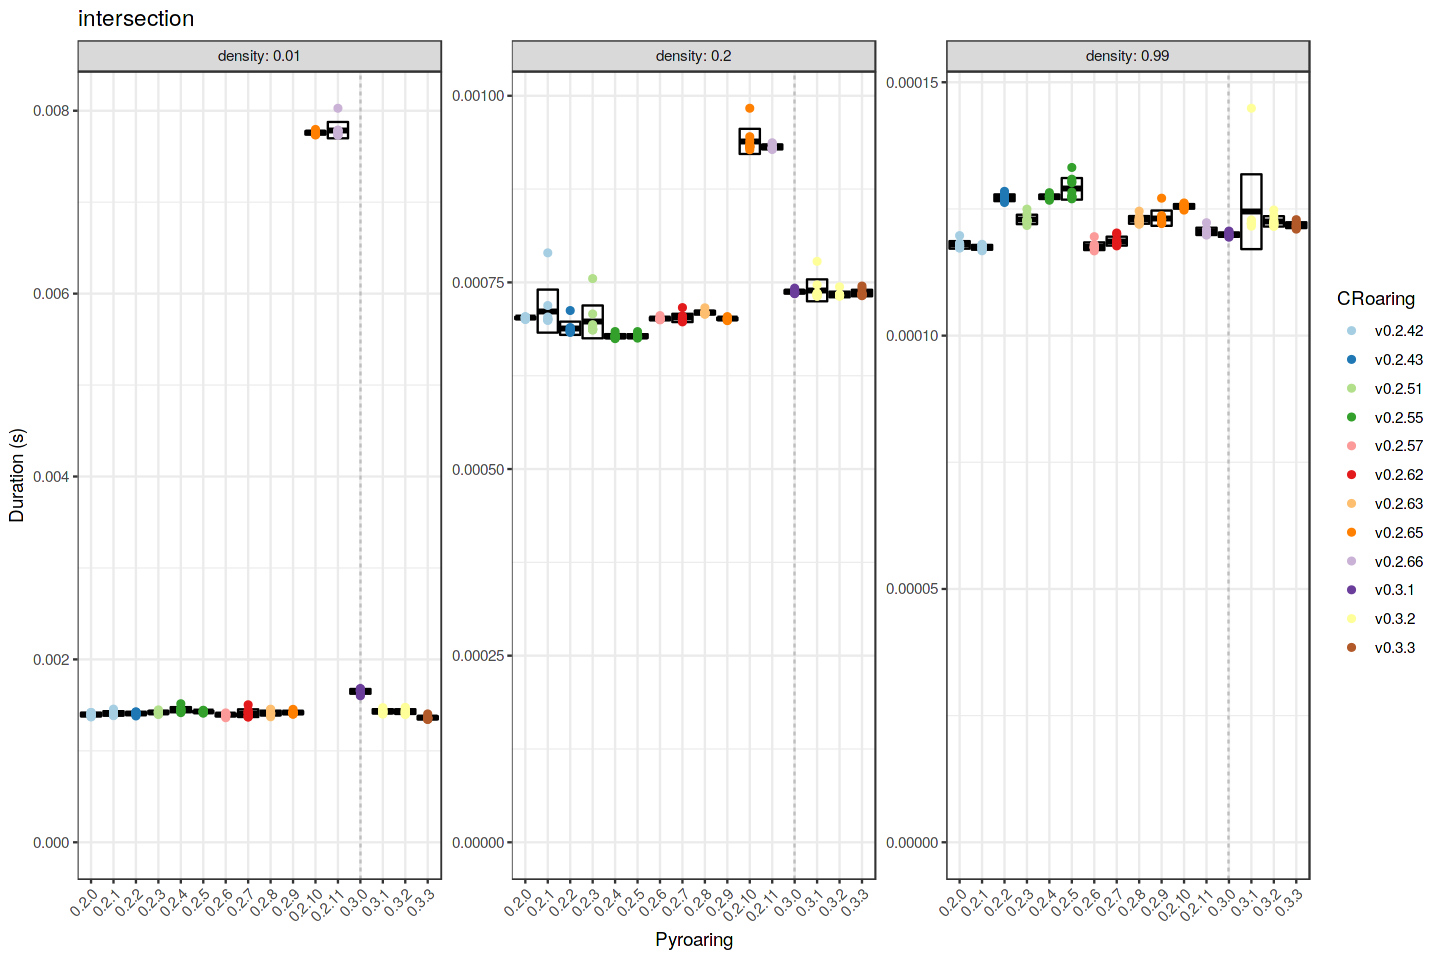

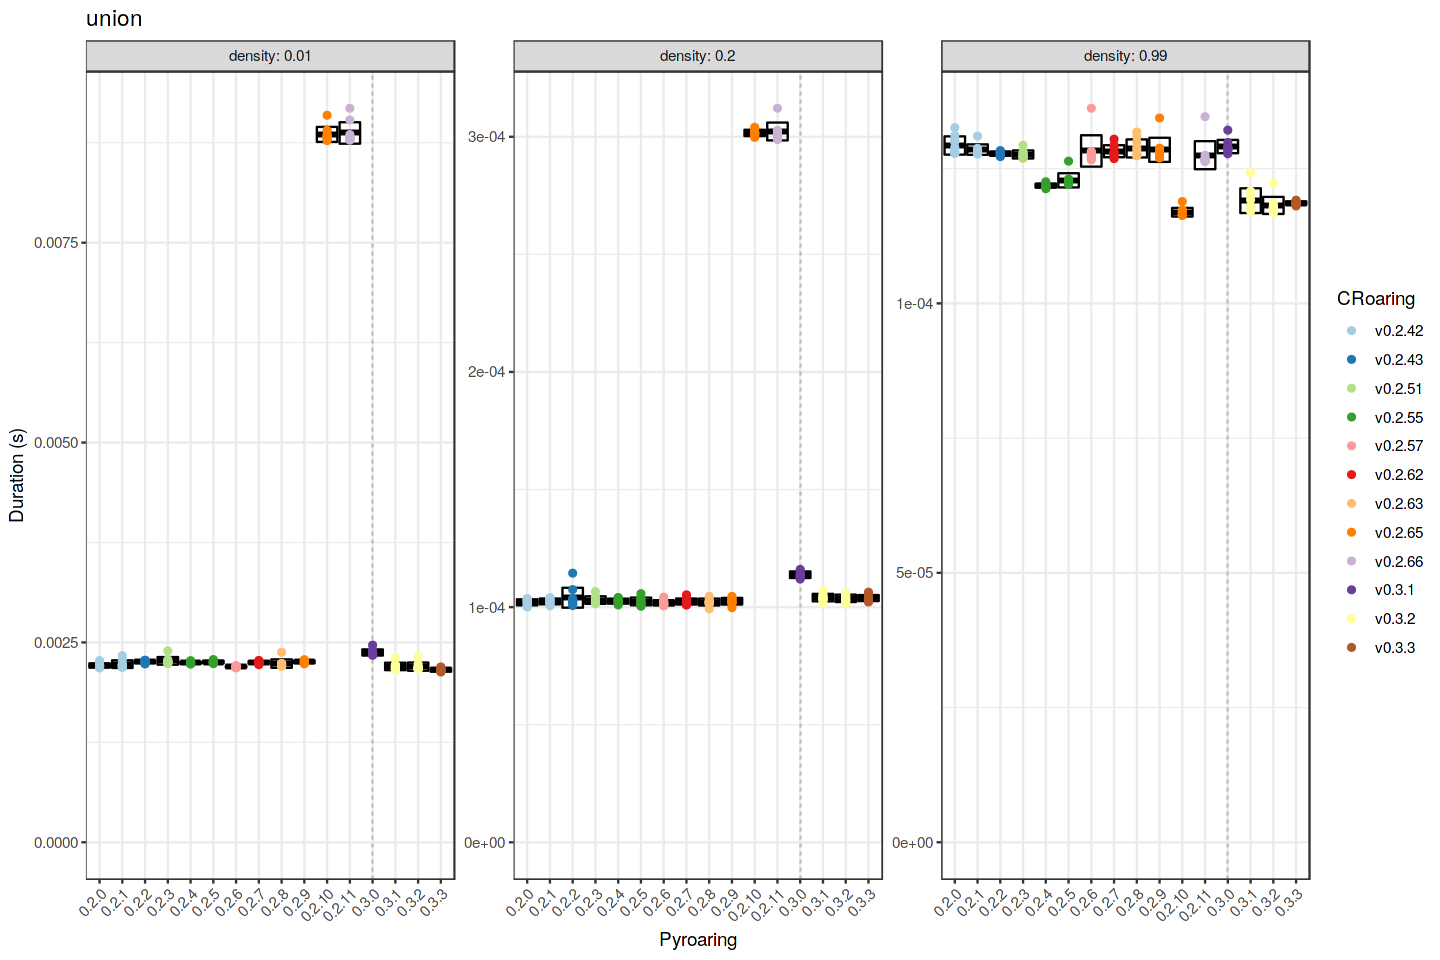

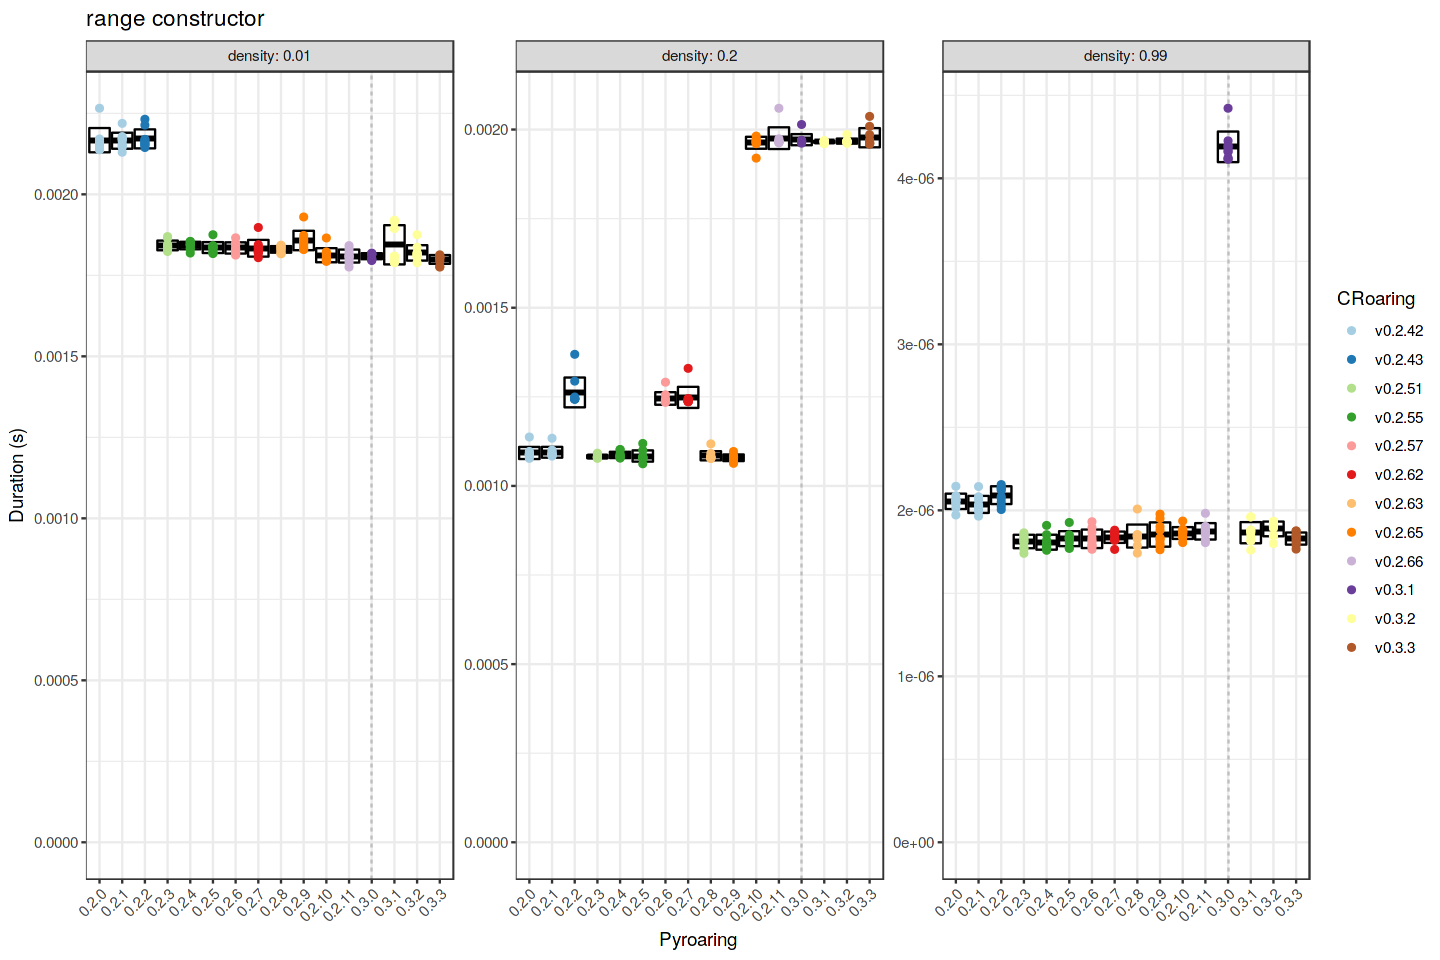

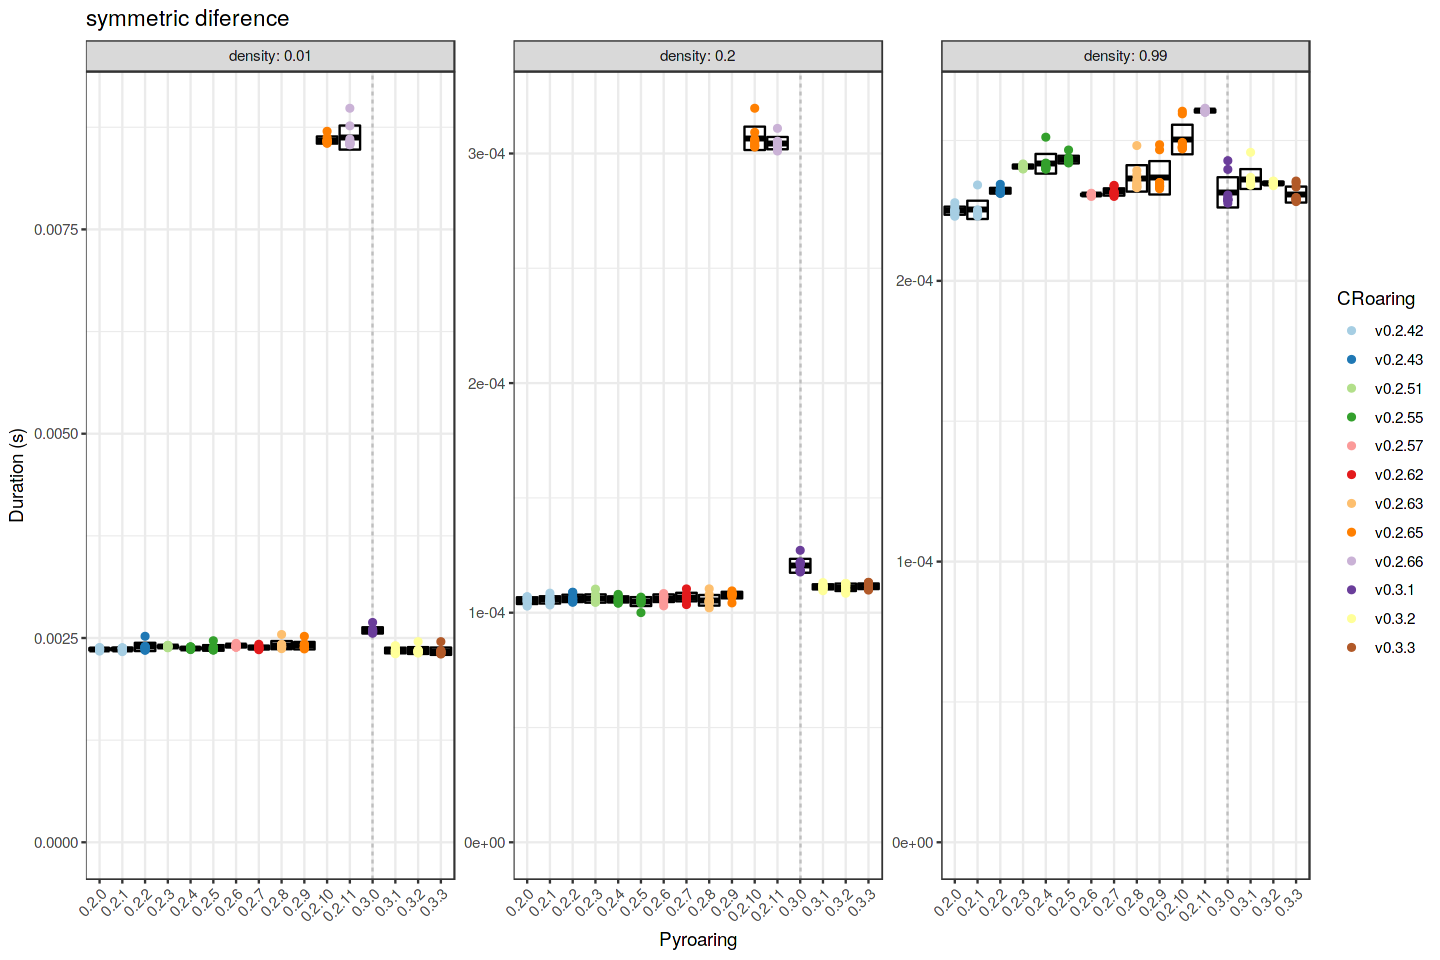

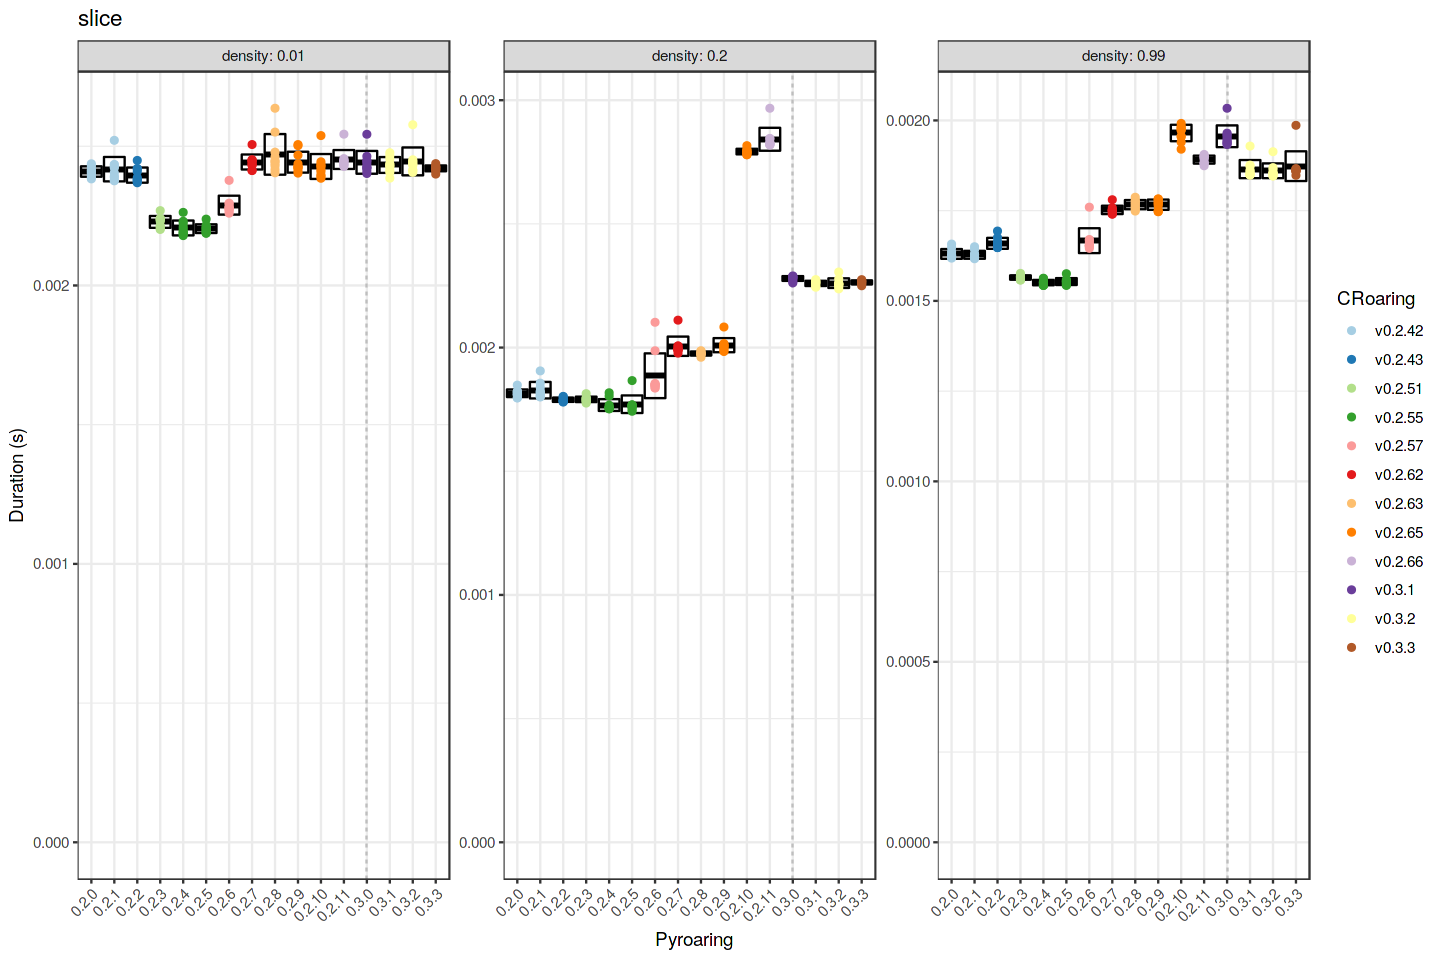

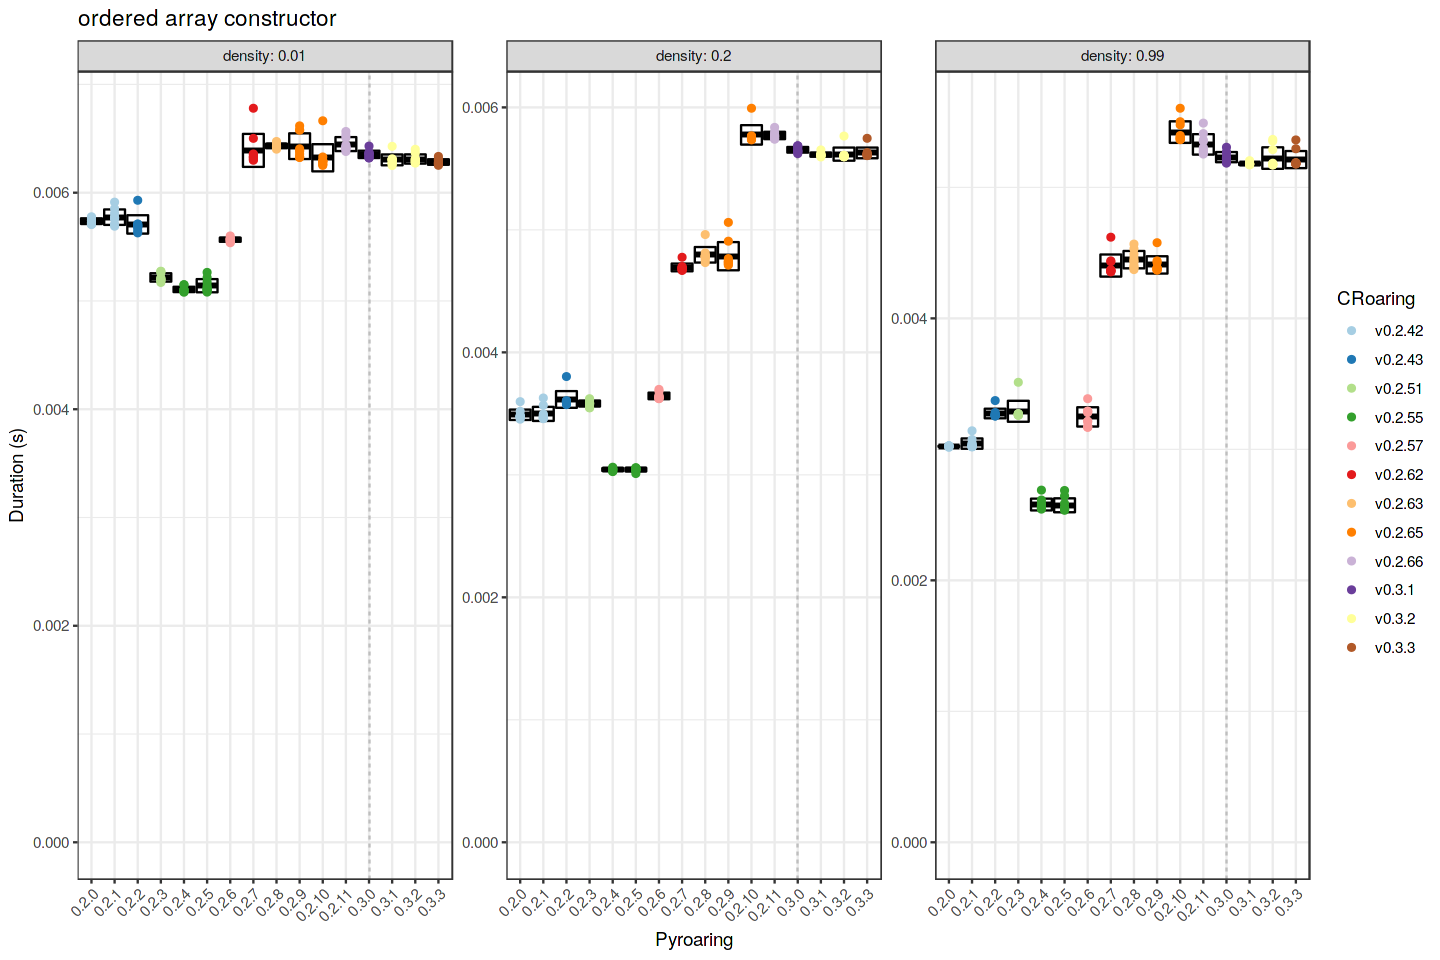

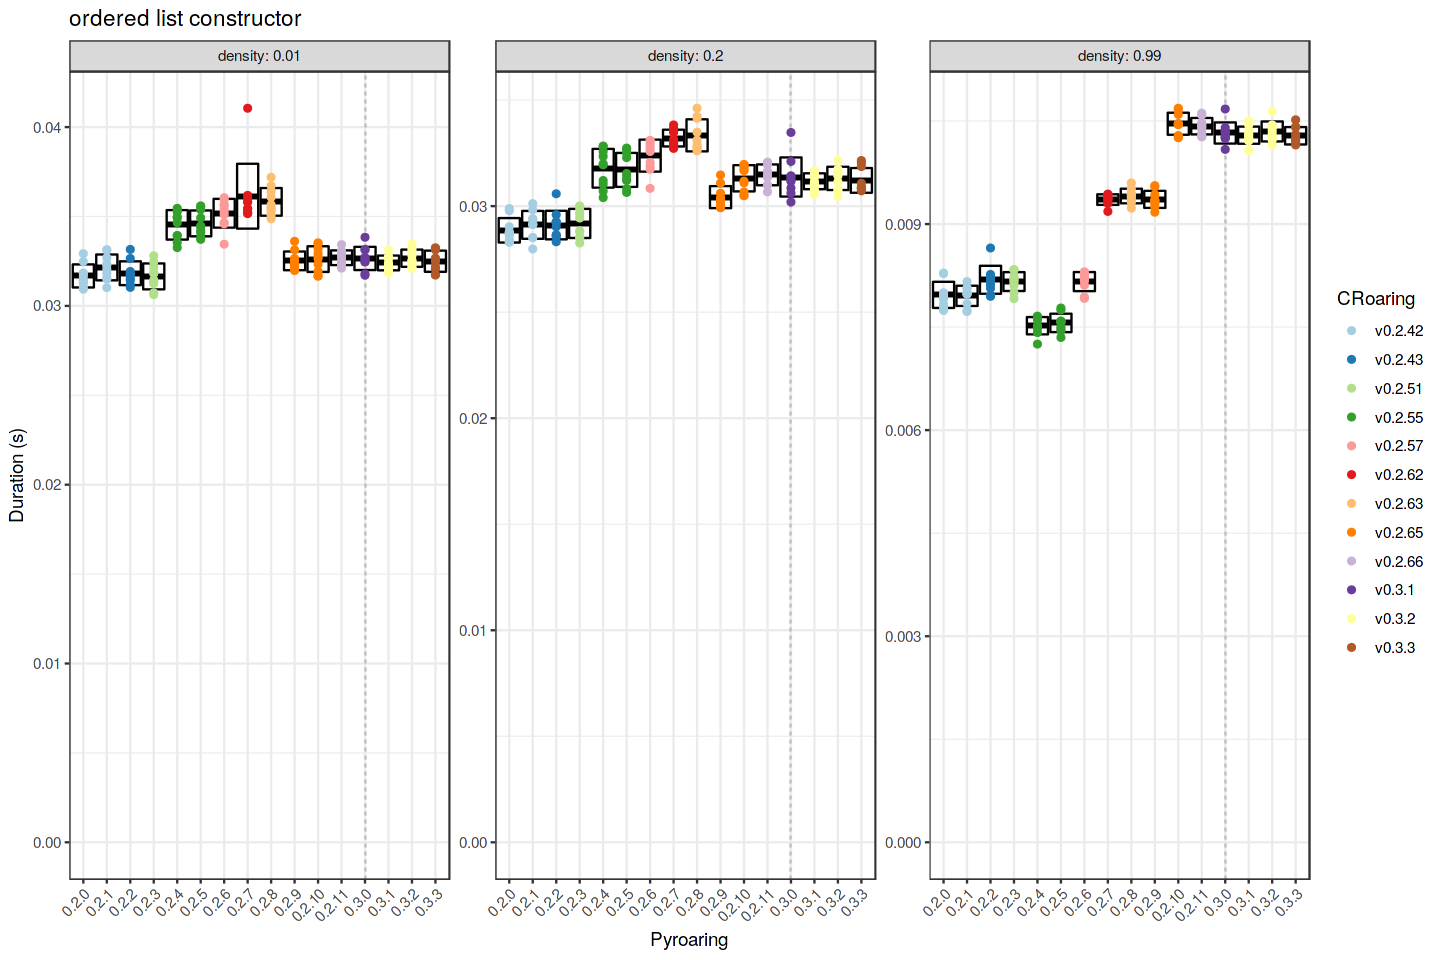

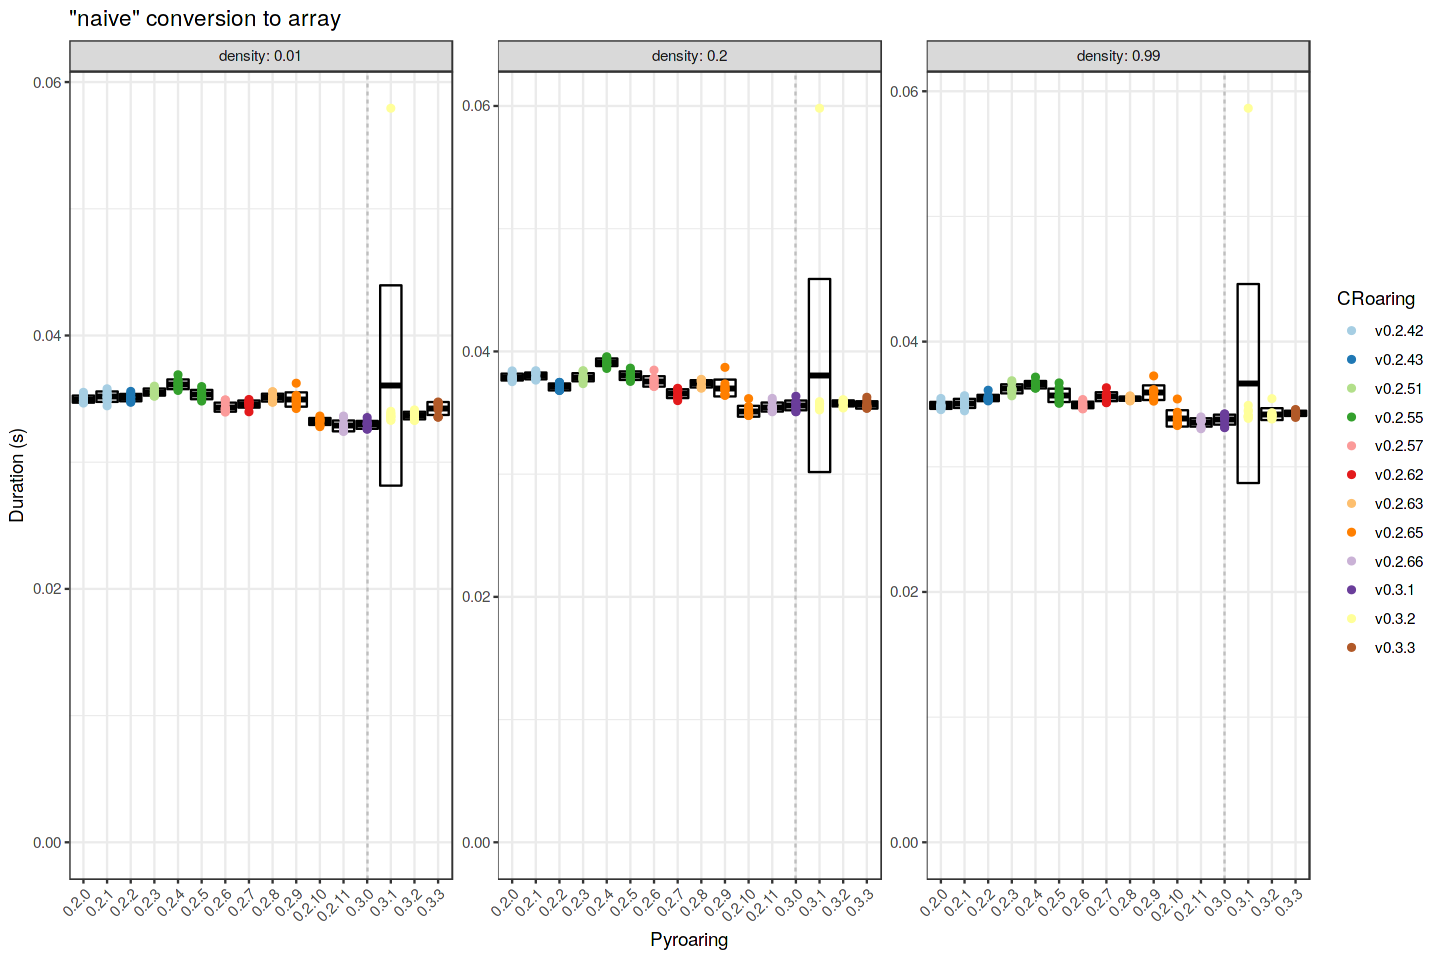

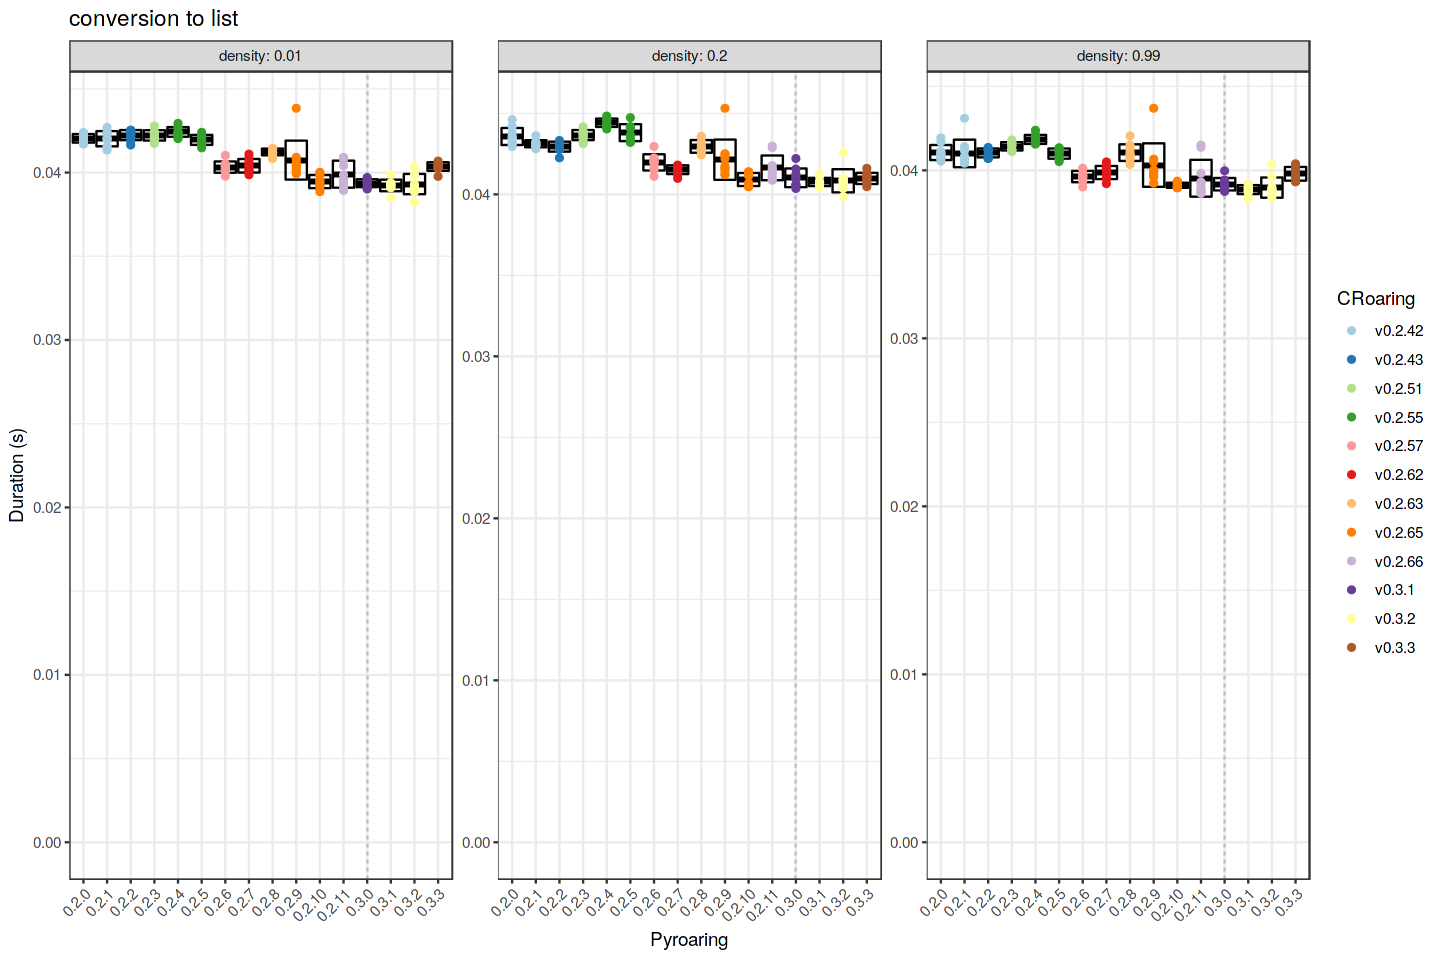

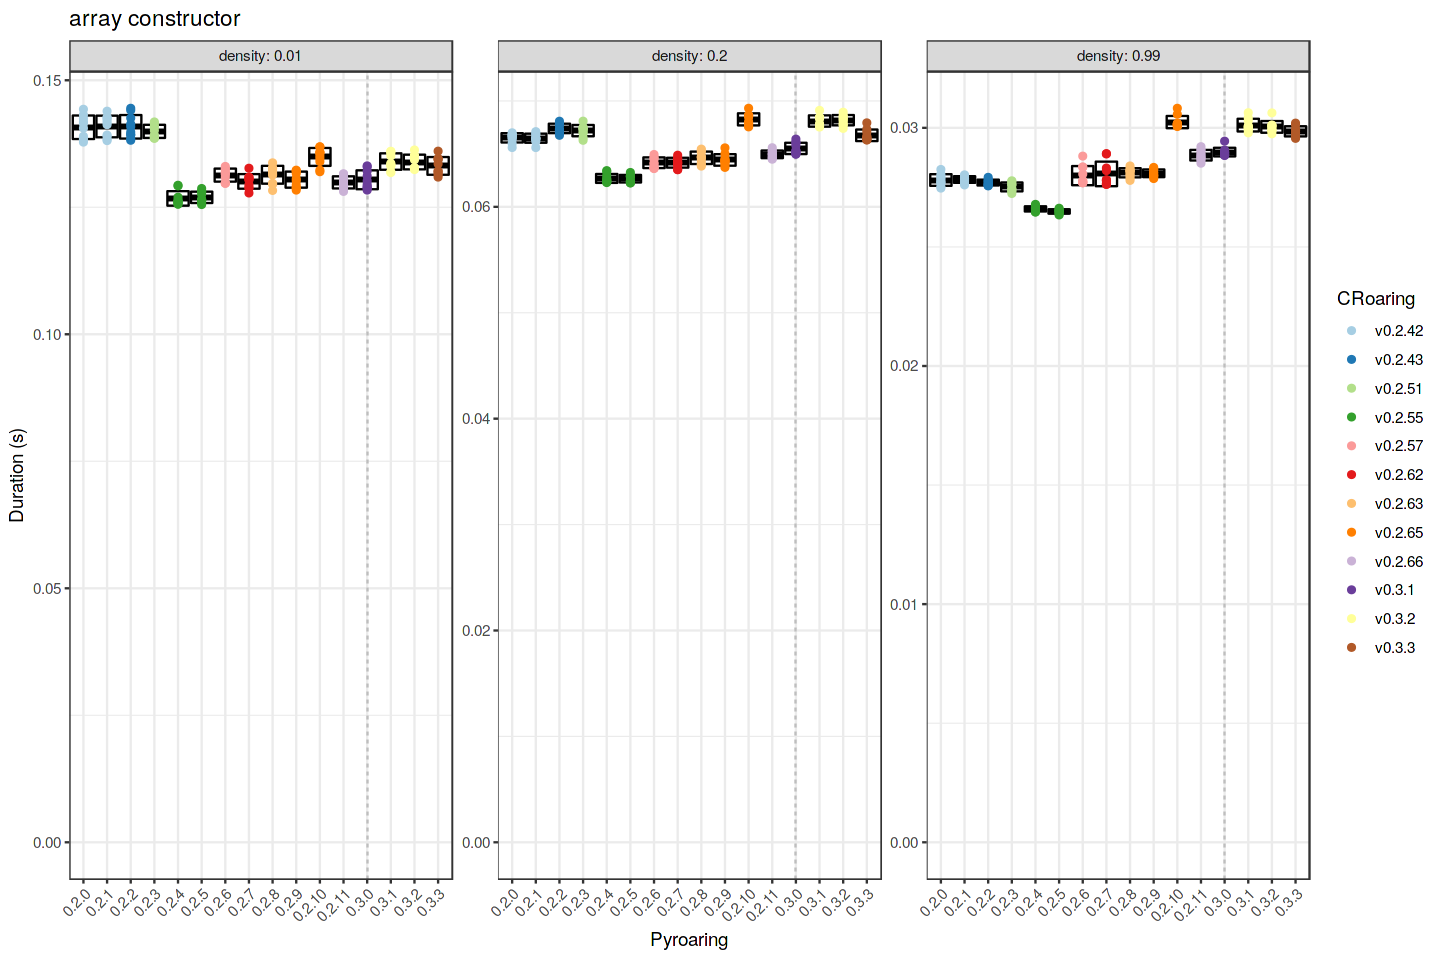

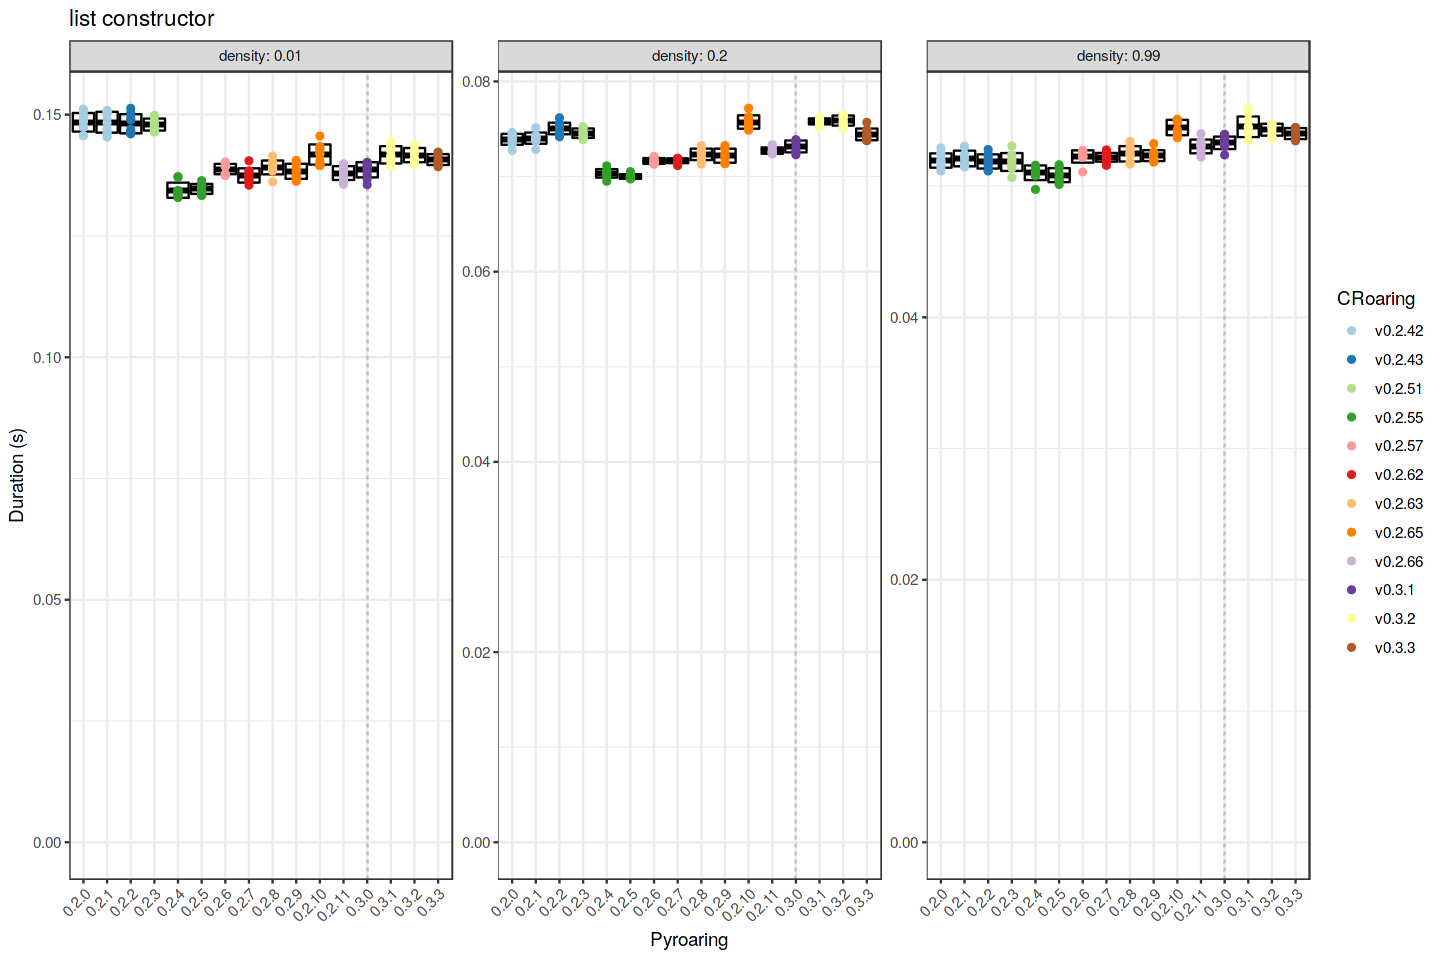

In [4]:
for(op in df %>% group_by(operation) %>% summarise(time=mean(time)) %>% arrange(time) %>% pull(operation) %>% unique()) {
    plot = df %>%
        filter(operation == op) %>%
        ggplot() +
            aes(x=pyroaring_version, y=time, color=croaring_version) +
            facet_wrap("density", scales="free", labeller="label_both") +
            geom_vline(xintercept="0.3.0", linetype="dashed", color="gray") +
            stat_summary(fun.data = "mean_cl_normal", colour = "black", geom="crossbar", fun.args=list(conf.int=.99)) +
            geom_point() +
            expand_limits(y=0) +
            theme_bw() +
            scale_color_brewer(palette="Paired") +
            theme(axis.text.x = element_text(angle = 45, hjust=1)) +
            labs(color="CRoaring") + xlab("Pyroaring") + ylab("Duration (s)") +
            ggtitle(op)
    print(plot)
}